# 4주차
- ChatGPT Tweets sentiment analysis
- 감성분석 모델링

## 데이터 이해
- Text: chatgpt 생성 트윗 내용
- negative: 트윗이 부정적 내용일 확률
- neutral: 트윗이 중립적 내용일 확률
- positive: 트윗이 긍정적 내용일 확률
- predicted_label: 예측된 트윗 라벨
- date: 트윗 수집 날짜
- likes: 트윗이 받은 좋아요 개수
- location: 트윗이 작성된 위치
- followers: 트윗 작성자의 팔로워 수 
- following: 트윗 작성자의 팔로잉 수
- retweets: 해당 트윗이 리트윗된 수
- replies: 해당 트윗에 달린 답글 수 

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

# preprocessing
import string
from sklearn.preprocessing import LabelEncoder

# visulization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling
from sklearn.pipeline import Pipeline # 전처리-모델링 과정을 연결해주는 시스템템
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# valuation
from sklearn.metrics import classification_report

In [2]:
# 데이터 불러오기
df = pd.read_csv("C:/Users/sssum/Downloads/chatgpt_sentiment.csv")
df.head()

,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies
0,If I were a journalist or reporter writing cli...,0.947877,0.040978,0.011144,negative,2023-02-10 23:59:49+00:00,1,Fukuoka 福岡 | Japan 日本,2012,388,0,0
1,Imagine if the mid season twist was that theyr...,0.031874,0.156266,0.811859,positive,2023-02-10 23:59:35+00:00,8,"Manhattan, NY",19855,5722,1,2
2,I see the difference between leader and employ...,0.158342,0.312784,0.528873,positive,2023-02-10 23:59:18+00:00,4,NaN,23,577,0,1
3,Which means your job is at risk Bill Gates say...,0.023860,0.931395,0.044745,neutral,2023-02-10 23:59:16+00:00,0,NaN,108,224,0,0
4,What have you been using Chatgpt for?,0.005627,0.968457,0.025916,neutral,2023-02-10 23:59:16+00:00,1,"Chicago, IL",11155,478,0,1


In [ ]:
# 데이터 기본 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975450 entries, 0 to 975449
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Text             975027 non-null  object 
 1   negative         975450 non-null  float64
 2   neutral          975450 non-null  float64
 3   positive         975450 non-null  float64
 4   predicted_label  975450 non-null  object 
 5   date             975450 non-null  object 
 6   likes            975450 non-null  int64  
 7   location         705265 non-null  object 
 8   followers        975450 non-null  int64  
 9   following        975450 non-null  int64  
 10  retweets         975450 non-null  int64  
 11  replies          975450 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 89.3+ MB


location 컬럼 결측치 있음

In [5]:
# 데이터 통계 정보 확인
df.describe()

,negative,neutral,positive,likes,followers,following,retweets,replies
count,975450.000000,975450.000000,975450.000000,975450.000000,9.754500e+05,9.754500e+05,975450.000000,975450.000000
mean,0.224028,0.437321,0.338650,11.961189,3.231735e+04,1.573738e+03,1.765541,1.114315
std,0.349075,0.374737,0.377395,355.771275,7.281230e+05,9.618419e+03,57.776420,36.731214
min,0.001543,0.005018,0.003674,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.006844,0.052123,0.018617,0.000000,8.600000e+01,1.480000e+02,0.000000,0.000000
50%,0.024687,0.355728,0.116684,1.000000,4.390000e+02,4.600000e+02,0.000000,0.000000
75%,0.254022,0.846569,0.746904,2.000000,2.041000e+03,1.214000e+03,0.000000,1.000000
max,0.986359,0.993227,0.990427,111653.000000,1.287402e+08,1.526451e+06,13072.000000,19942.000000


In [13]:
# 범주형 컬럼 분포 확인
df.describe(include='object')

,Text,date,location
count,704971,704971,704971
unique,625655,646855,93616
top,ChatGPT,2023-01-12 10:30:34+00:00,United States
freq,9992,31,11208


- negative, neutral, positive 라벨링을 진행하고, 각 감성마다 분포 파악
- 데이터 개수가 약 97만개로 모델링시 시간이 매우 오래 걸리는 점을 감안하여 샘플링을 진행
- text와 라벨 변수(감성) 외에 likes, follwers 등 변수들은 EDA 과정에서 활용하고 모델링에서는 활용하지 않음

In [6]:
# 리뷰 텍스트 형태 확인
df['Text'][0]

"If I were a journalist or reporter writing click-bait for a living then I'd be worried: BuzzFeed Inc. said it would rely on ChatGPT creator OpenAI to enhance its quizzes and personalize some content for audiences via"

텍스트는 html 형식이 아니므로 소문자화, 구두점 제거, stopwords 제거로 1차 전처리 과정을 거침

## 데이터 전처리
이번 챕터는 텍스트 분석을 진행해야 하므로 먼저 데이터 전처리를 진행 후 EDA 진행

In [8]:
# 라벨링 0-negative, 1-positive, 2-neutral
label_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
df['sentiment_label'] = df['predicted_label'].map(label_mapping)

df.head()

,Text,negative,neutral,positive,predicted_label,date,likes,location,followers,following,retweets,replies,sentiment_label
0,If I were a journalist or reporter writing cli...,0.947877,0.040978,0.011144,negative,2023-02-10 23:59:49+00:00,1,Fukuoka 福岡 | Japan 日本,2012,388,0,0,0
1,Imagine if the mid season twist was that theyr...,0.031874,0.156266,0.811859,positive,2023-02-10 23:59:35+00:00,8,"Manhattan, NY",19855,5722,1,2,1
2,I see the difference between leader and employ...,0.158342,0.312784,0.528873,positive,2023-02-10 23:59:18+00:00,4,NaN,23,577,0,1,1
3,Which means your job is at risk Bill Gates say...,0.023860,0.931395,0.044745,neutral,2023-02-10 23:59:16+00:00,0,NaN,108,224,0,0,2
4,What have you been using Chatgpt for?,0.005627,0.968457,0.025916,neutral,2023-02-10 23:59:16+00:00,1,"Chicago, IL",11155,478,0,1,2


In [9]:
# negative와 같이 확률값 컬럼과 predicted_label 컬럼 제거
df = df.drop(columns=['negative', 'positive', 'neutral', 'predicted_label'], axis=1)
df.head()

,Text,date,likes,location,followers,following,retweets,replies,sentiment_label
0,If I were a journalist or reporter writing cli...,2023-02-10 23:59:49+00:00,1,Fukuoka 福岡 | Japan 日本,2012,388,0,0,0
1,Imagine if the mid season twist was that theyr...,2023-02-10 23:59:35+00:00,8,"Manhattan, NY",19855,5722,1,2,1
2,I see the difference between leader and employ...,2023-02-10 23:59:18+00:00,4,NaN,23,577,0,1,1
3,Which means your job is at risk Bill Gates say...,2023-02-10 23:59:16+00:00,0,NaN,108,224,0,0,2
4,What have you been using Chatgpt for?,2023-02-10 23:59:16+00:00,1,"Chicago, IL",11155,478,0,1,2


In [12]:
# location 컬럼 결측치 제거
df = df.dropna(axis=0, how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704971 entries, 0 to 975449
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Text             704971 non-null  object
 1   date             704971 non-null  object
 2   likes            704971 non-null  int64 
 3   location         704971 non-null  object
 4   followers        704971 non-null  int64 
 5   following        704971 non-null  int64 
 6   retweets         704971 non-null  int64 
 7   replies          704971 non-null  int64 
 8   sentiment_label  704971 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 53.8+ MB


## EDA

<Axes: xlabel='sentiment_label', ylabel='count'>

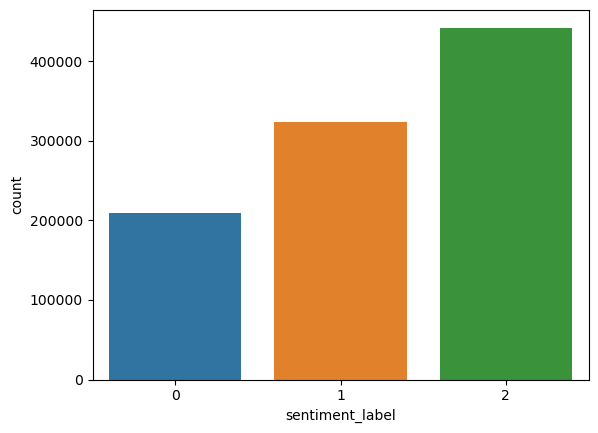

In [10]:
# 라벨 변수 분포 확인
sns.countplot(x='sentiment_label', data=df)

- 중립이 가장 많고, 긍정, 부정순
- 라벨 변수 분포를 동일하게 샘플링 진행

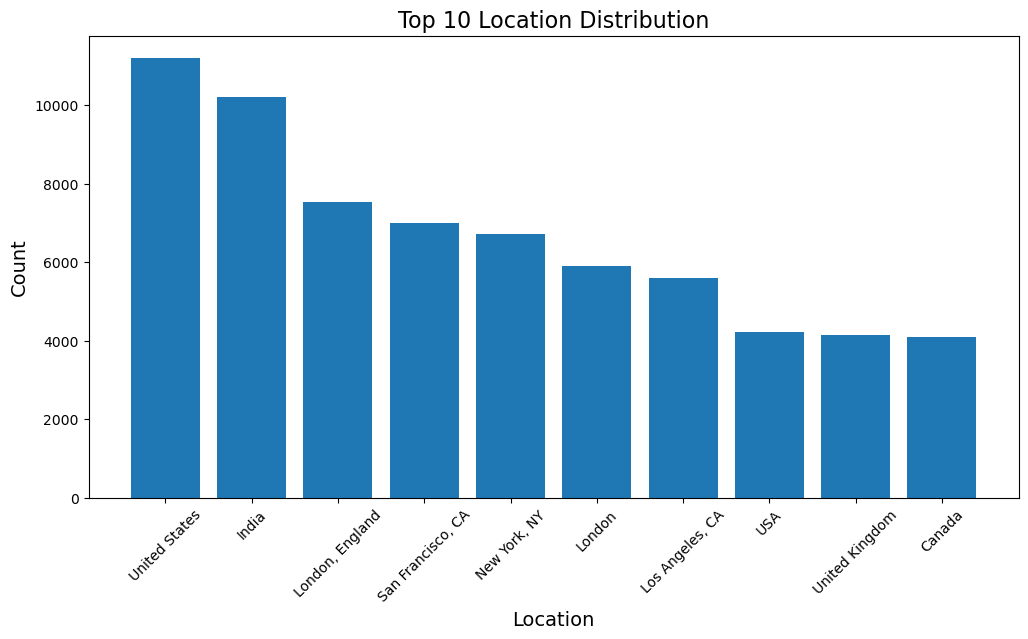

In [14]:
# location 컬럼 상위 10개 분포 확인
top_10_locations = df['location'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_locations.index, top_10_locations.values)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Top 10 Location Distribution', fontsize=16)
plt.xticks(rotation=45)
plt.show()

- 미국에서 작성된 트윗이 가장 많고, 그 다음으로 인도가 많음
- 동일한 나라여도 다르게 작성된 값이 많음
- 모델링에는 사용하지 않는 것으로 결정함

In [17]:
# 좋아요 개수 상위 10개 텍스트값 확인
pd.set_option('display.max_colwidth', None)
top_10_likes = df.nlargest(10, 'likes')[['Text', 'likes']]

top_10_likes

,Text,likes
170270,Time it took to get 100 million users: Netflix: 10 years Gmail: 5 years Twitter: 5 years Facebook: 4.5 years WhatsApp: 3.5 years Instagram: 2.5 years TikTok: 9 months ChatGPT: 2 months Pirate Bay: 1 day after Netflix cancelled shared passwords and Gen-Z discovered torrents.,111653
950217,"POV: You're a Senior Data Engineer at Twitter. Elon asks what you've done this week. You've done nothing. Frantically, you open ChatGPT.",62310
188438,ChatGPT is everywhere and everyone is using it. But most academics don't know how to use it *smartly.* Here's how to use ChatGPT intelligently (and ethically) for academic purposes:,60325
656600,ChatGPT is a FREE assistant. But most people dont know the best ways to use it. Here are 8 ways ChatGPT can save you thousands of hours in 2023:,60197
368458,ChatGPT passed a Wharton MBA exam. Time to overhaul education.,58667
925357,ChatGPT launched on wednesday. today it crossed 1 million users!,52707
647959,Everyones using ChatGPT. But almost everyone's STUCK in beginner mode. 10 techniques to get massively ahead with AI: (cut-and-paste these prompts),47592
456058,imagine a ChatGPT browser extension that reads the Terms and Conditions agreement and flags anything that is non-standard,42849
349058,chatgpt will never replicate the charm and syntax of an undergraduate paper where the student has neither been to class nor read more than the abstract of a paper there's a magic nothingness that they're able to conjure with sheer grit and desperation that a.i. could never,42441
106346,Looks like ChatGPT is gonna need to go in the shop for repairs because it's been BUCK BROKEN,41801


- 111,653개의 좋아요를 받은 트윗 내용은 1억명의 고객을 모으는데 걸린 시간을 각 플랫폼별로 비교한 내용, ChatGPT가 그만큼 고객을 빨리 모았다는 것을 말함
- 62,310개의 좋아요를 받은 트윗 내용은 ChatGPT를 홍보하기 위한 내용

In [18]:
# 리트윗 개수 상위 10개 텍스트값 확인
top_10_retweets = df.nlargest(10, 'retweets')[['Text', 'retweets']]

top_10_retweets

,Text,retweets
656600,ChatGPT is a FREE assistant. But most people dont know the best ways to use it. Here are 8 ways ChatGPT can save you thousands of hours in 2023:,13072
188438,ChatGPT is everywhere and everyone is using it. But most academics don't know how to use it *smartly.* Here's how to use ChatGPT intelligently (and ethically) for academic purposes:,12506
936279,We asked Open AI's ChatGPT what it thought of the unique architecture that Quai has implemented to solve the blockchain trilemma... What do you think of its response?,10526
170270,Time it took to get 100 million users: Netflix: 10 years Gmail: 5 years Twitter: 5 years Facebook: 4.5 years WhatsApp: 3.5 years Instagram: 2.5 years TikTok: 9 months ChatGPT: 2 months Pirate Bay: 1 day after Netflix cancelled shared passwords and Gen-Z discovered torrents.,10242
502485,Best AI Tools You Need To Know,9891
427949,"Exclusive: OpenAI used outsourced Kenyan workers earning less than per hour to make ChatGPT less toxic, my investigation found (Thread)",9545
106346,Looks like ChatGPT is gonna need to go in the shop for repairs because it's been BUCK BROKEN,9517
600060,ultra-modern generative ai: AI2 AI21 mdm gpt-J gpt-3 x-clip bloom cohere gopher dalle 2 craiyon tabnine jukebox chatGPT *** anthropic codegeex nvidia get3d dreamfusion stable diffusion meta make-a-video,9501
667945,AI tools that didn't exist one year ago: ChatGPT Whisper GPT-3 Codex GitHub Copilot InstructGPT Text-to-product AI slides DALLE + API Midjourney Stable Diffusion Runway videos Email AI AI chrome extensions Replit Ghostwriter No-code AI app builders Ben's bites what else?,8989
647959,Everyones using ChatGPT. But almost everyone's STUCK in beginner mode. 10 techniques to get massively ahead with AI: (cut-and-paste these prompts),8796


- 13,072개의 리트윗을 받은 트윗의 내용은 ChatGPT를 사용하는 8가지 방법에 대한 내용
- 12,506개의 리트윗을 받은 트윗의 내용은 ChatGPT를 사용해서 공부하는 방법에 대한 내용

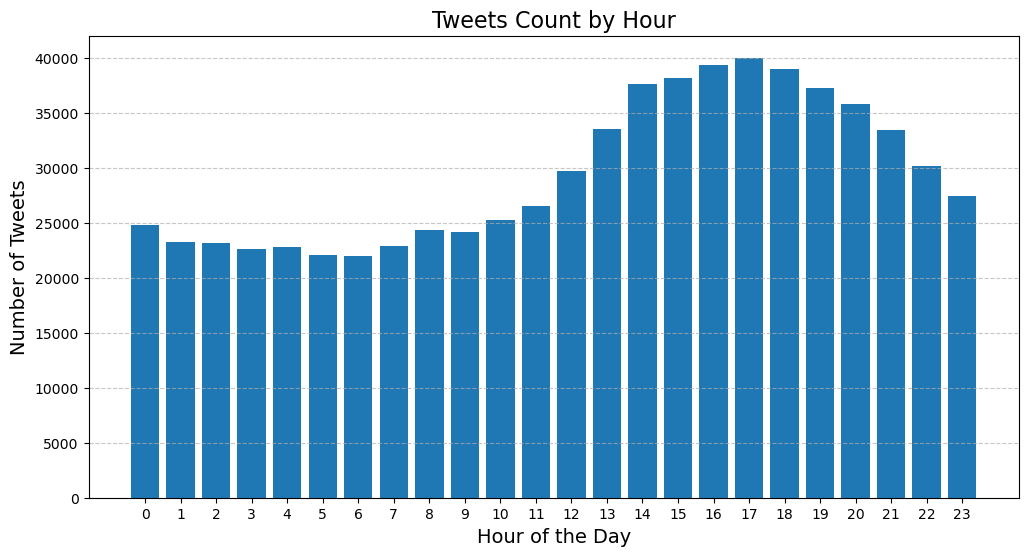

In [21]:
# 트윗이 작성된 시간대 시각화
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour # 시간대 추출출

hourly_counts = df['hour'].value_counts().sort_index() # 시간대별 트윗개수 집계계

plt.figure(figsize=(12, 6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.title('Tweets Count by Hour', fontsize=16)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

오후 6시에 가장 많은 트윗이 작성되었고, 오전 5, 6시에 비교적 가장 적은 트윗이 작성됨 

## 모델링

In [19]:
# 각 클래스별 비율을 동일하게 샘플링
target_column = 'sentiment_label'
num_classes = df[target_column].nunique()
samples_per_class = 10000 // num_classes  # 각 클래스당 샘플 개수

data = df.groupby(target_column).sample(n=samples_per_class, random_state=42)

print(data[target_column].value_counts())  # 분포 확인
print(data.shape)  # 샘플 개수 확인

0    3333
1    3333
2    3333
Name: sentiment_label, dtype: int64
(9999, 9)


In [22]:
# 샘플링 데이터 값 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 597112 to 221062
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Text             9999 non-null   object
 1   date             9999 non-null   object
 2   likes            9999 non-null   int64 
 3   location         9999 non-null   object
 4   followers        9999 non-null   int64 
 5   following        9999 non-null   int64 
 6   retweets         9999 non-null   int64 
 7   replies          9999 non-null   int64 
 8   sentiment_label  9999 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 781.2+ KB


In [25]:
# 모델링에 사용하지 않는 컬럼 제거
data = data[['Text', 'sentiment_label']]
data.head()

,Text,sentiment_label
597112,ChatGPT perfectly highlights the outdated educational approach and an urgent need to adap,0
713627,"Trying to get chatgpt to decide on my next mtg commander deck but it doesnt even know what Kambal does, fkn scrub",0
676915,"Its not literal (external) censorship. Its OpenAI making a huge effort to block ChatGPT anything that would be even remotely controversial, biased or aggressive. Even OpenAI said they will lower th",0
587527,"In every one of these scenarios ChatGPT opted to save the most lives, until white men were added to the equation. Is ChatGPT racist? What if this was AI controlled EVs deciding who lives in a car accident? Scary stuff",0
357356,Asking some stupid questions to,0


In [29]:
# countvectorizer에서 수행하지 못하는 구두점 제거
data['nopunc'] = data['Text'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
data.head()

,Text,sentiment_label,nopunc
597112,ChatGPT perfectly highlights the outdated educational approach and an urgent need to adap,0,ChatGPT perfectly highlights the outdated educational approach and an urgent need to adap
713627,"Trying to get chatgpt to decide on my next mtg commander deck but it doesnt even know what Kambal does, fkn scrub",0,Trying to get chatgpt to decide on my next mtg commander deck but it doesnt even know what Kambal does fkn scrub
676915,"Its not literal (external) censorship. Its OpenAI making a huge effort to block ChatGPT anything that would be even remotely controversial, biased or aggressive. Even OpenAI said they will lower th",0,Its not literal external censorship Its OpenAI making a huge effort to block ChatGPT anything that would be even remotely controversial biased or aggressive Even OpenAI said they will lower th
587527,"In every one of these scenarios ChatGPT opted to save the most lives, until white men were added to the equation. Is ChatGPT racist? What if this was AI controlled EVs deciding who lives in a car accident? Scary stuff",0,In every one of these scenarios ChatGPT opted to save the most lives until white men were added to the equation Is ChatGPT racist What if this was AI controlled EVs deciding who lives in a car accident Scary stuff
357356,Asking some stupid questions to,0,Asking some stupid questions to


In [35]:
# 데이터 분할
X = data['nopunc'].values.astype('str')
y = data['sentiment_label']

In [36]:
# countvectorizer 함수에 학습
cv = CountVectorizer(lowercase=True, stop_words='english')
X = cv.fit_transform(X)

In [37]:
# train, test 데이터 분할
train_input, test_input, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# NaiveBayes 모델링
nb = MultinomialNB()
nb.fit(train_input, train_target)
pred = nb.predict(test_input)

In [45]:
# train 성능 확인
print(nb.score(train_input, train_target))

0.8549818727340918


In [41]:
# test 성능 확인
print(classification_report(test_target, pred))

              precision    recall  f1-score   support

           0       0.62      0.65      0.64       684
           1       0.58      0.71      0.64       647
           2       0.61      0.45      0.52       669

    accuracy                           0.60      2000
   macro avg       0.61      0.60      0.60      2000
weighted avg       0.61      0.60      0.60      2000



성능 평가 결과, 과적합 발생

In [49]:
# 파이프라인 생성
pipeline = Pipeline([
    ('bow', CountVectorizer(lowercase=True, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [50]:
# 데이터 분할
X = data['nopunc']
y = data['sentiment_label']

train_input, test_input, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# 파이프라인 학습
pipeline.fit(train_input, train_target)

Pipeline(steps=[('bow', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [52]:
# 예측값 생성
pred_target = pipeline.predict(test_input)

In [54]:
# train 성능 평가
print(pipeline.score(train_input, train_target))

0.8659832479059882


In [55]:
# test 성능 평가
print(classification_report(test_target, pred_target))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       684
           1       0.56      0.78      0.65       647
           2       0.63      0.45      0.53       669

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.60      2000
weighted avg       0.61      0.61      0.60      2000

